In [2]:
import sys
import os
import numpy as np
import supervision as sv
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict

src_path = os.path.abspath(os.path.join('../../../', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    

from tools.data_processor import DataProcessor
from tools.frame_processors import SupervisionVertexProcessorWithLandmarkFrontalization
from tools.frame_preprocessors import TextureFrontalizationPreprocessor, FaceExtractionPreprocessor

In [3]:
EXPRESSIONS_PATH = os.path.abspath(os.path.join('..', 'data', 'expressions'))
REFERENCE_POINTS = "key_points_xyz.npy"
REFERENCE_POINTS_PATH = os.path.abspath(os.path.join('..', 'data', 'reference_points', REFERENCE_POINTS))
MODELS_PATH = os.path.join(src_path, "models", "frontalization_models")

In [4]:
class SVPWLF_dummy(SupervisionVertexProcessorWithLandmarkFrontalization):
    def __init__(self, reference_points_path: str):
        super().__init__(reference_points_path)
        self.keypoints_history = []
    
    def process(self, frame: np.ndarray) -> np.ndarray:        
        processed_frame = self._model.process(frame)
        image_to_frontalize_xyz = self._get_xyz_from_processed_frame(processed_frame)
        frontalized_keypoints = self._procrustes_analysis(
            image_to_frontalize_xyz[0], self._reference_points[0]
        )
        frontalized_keypoints = self._get_xy_from_xyz(frontalized_keypoints)
        
        self.keypoints_history.append(frontalized_keypoints)

        return self._make_face_mesh(frontalized_keypoints)

In [5]:
class DataProcessor_dummy(DataProcessor):
    def process_video(
        self,
        source_path: str,
        target_path: str = None,
    ):
        """
        Overrides the regular process_video to not display the output frame but rather show
        the accumulated landmark data.

        Args:
            source_path (str): The path to the source video.
            target_path (str): The path to the target video
        """
        for frame in sv.get_video_frames_generator(source_path):
            annotated_frame = self._handle_frame(frame)
            if annotated_frame is None:
                continue
        
        return self._frame_processor.keypoints_history


In [6]:
def get_average_landmarks_distance(video_path: str, landmark_indexes: list, reference_landmark_index: list):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        distance_sum = 0
        for landmark_idx in landmark_indexes:
            distance_sum += math.sqrt(
                (keypoint[reference_landmark_index][0] - keypoint[landmark_idx][0])**2 +
                (keypoint[reference_landmark_index][1] - keypoint[landmark_idx][1])**2
            )
        output.append(distance_sum / len(landmark_indexes))

    return output

In [6]:
emotions_distance = {}

## All landmarks

In [ ]:
LANDMARK_INDEXES = [
    76, 306,  # mouth corners
    74, 73, 72, 11, 302, 303, 304, # upper lip
    90, 180, 85, 16, 315, 404, 320, # lower lip
    33, 161, 159, 157, 133, 154, 145, 163,  # left eye
    70, 63, 105, 66, 107,  # left eyebrow
    362, 384, 386, 388, 263, 390, 374, 381,  # right eye
    300, 293, 334, 296, 336,  # right eyebrow
    1, 5, 197, 168  # nose
]

REFERENCE_LANDMARK_INDEX = 0  # Middle of face

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_distance:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_distance[emotion] = get_average_landmarks_distance(emotion_video, LANDMARK_INDEXES, REFERENCE_LANDMARK_INDEX)

Processing videos: 100%|██████████| 6/6 [02:22<00:00, 23.72s/it]


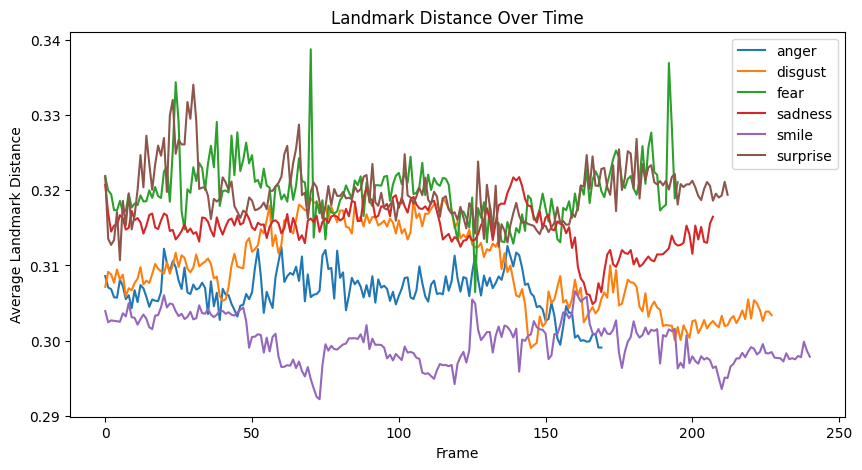

In [8]:
plt.figure(figsize=(10, 5))

for emotion, distances in emotions_distance.items():
    plt.plot(distances, label=emotion)

plt.xlabel('Frame')
plt.ylabel('Average Landmark Distance')
plt.title('Landmark Distance Over Time')
plt.legend()
plt.show()

## Particular face part movement over time

In [7]:
def get_average_landmarks_distance_areas(video_path: str, landmark_areas_indexes: dict, reference_landmark_index: list):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        distances = defaultdict(lambda: 0)
        for area, landmark_idxs in landmark_areas_indexes.items():
            for landmark_idx in landmark_idxs:
                distances[area] += math.sqrt(
                    (keypoint[reference_landmark_index][0] - keypoint[landmark_idx][0])**2 +
                    (keypoint[reference_landmark_index][1] - keypoint[landmark_idx][1])**2
                )
        output.append({area: distance / len(landmark_areas_indexes[area]) for area, distance in distances.items()})

    return output

In [ ]:
LANDMARKS = {
    "mouth": [
        76, 306,  # mouth corners
        74, 73, 72, 11, 302, 303, 304, # upper lip
        90, 180, 85, 16, 315, 404, 320 # lower lip
    ],
    "eyes": [
        33, 161, 159, 157, 133, 154, 145, 163,  # left eye
        362, 384, 386, 388, 263, 390, 374, 381  # right eye
    ],
    "eyebrows": [
        70, 63, 105, 66, 107,  # left eyebrow
        300, 293, 334, 296, 336  # right eyebrow
    ]
}

REFERENCE_LANDMARK_INDEX = 0  # Middle of face

emotions_distance = {}

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_distance:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_distance[emotion] = get_average_landmarks_distance_areas(emotion_video, LANDMARKS, REFERENCE_LANDMARK_INDEX)

Processing videos: 100%|██████████| 6/6 [02:15<00:00, 22.64s/it]


In [31]:
emotions_distance

{'anger': [{'mouth': 0.14107011686605878,
   'eyes': 0.37695188723241246,
   'eyebrows': 0.5034856093457446},
  {'mouth': 0.16079391185136077,
   'eyes': 0.36360753465134377,
   'eyebrows': 0.487854156195387},
  {'mouth': 0.15295491746565,
   'eyes': 0.3683641912695379,
   'eyebrows': 0.488699080191044},
  {'mouth': 0.15252742041216885,
   'eyes': 0.366272746783055,
   'eyebrows': 0.4891856661839844},
  {'mouth': 0.1505474927328591,
   'eyes': 0.36703868984508803,
   'eyebrows': 0.49019049098873085},
  {'mouth': 0.15753763307747648,
   'eyes': 0.3674505830273102,
   'eyebrows': 0.48924690806187854},
  {'mouth': 0.15475023712369432,
   'eyes': 0.3670418372857039,
   'eyebrows': 0.4900750998444069},
  {'mouth': 0.14757491852936533,
   'eyes': 0.3688766174665121,
   'eyebrows': 0.49059043039613304},
  {'mouth': 0.14998413894053894,
   'eyes': 0.36839352232502753,
   'eyebrows': 0.49013046736596805},
  {'mouth': 0.14154152747599882,
   'eyes': 0.3692215179167561,
   'eyebrows': 0.494294834

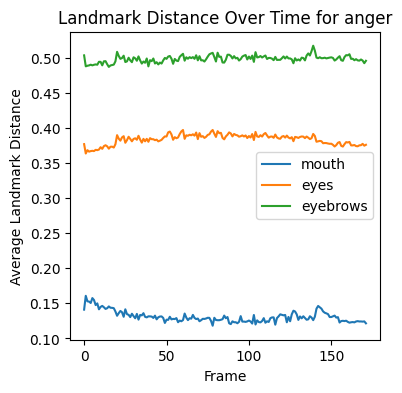

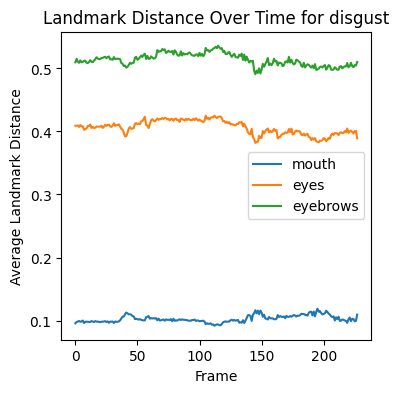

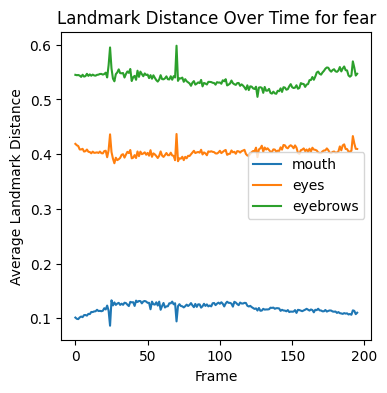

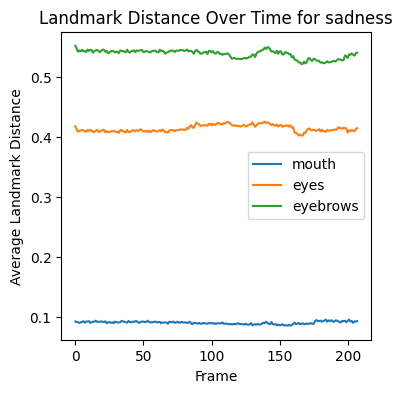

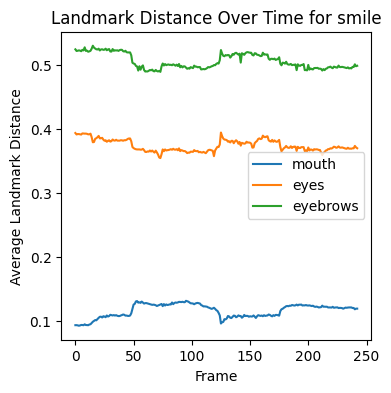

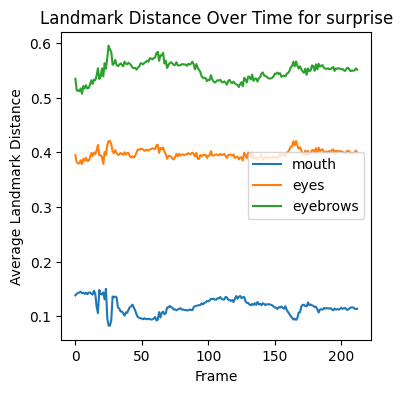

In [34]:
for emotion, distances in emotions_distance.items():
    plt.figure(figsize=(4, 4))

    for area in LANDMARKS.keys():
        area_distances = [d[area] for d in distances]
        plt.plot(area_distances, label=area)
    
    plt.xlabel('Frame')
    plt.ylabel('Average Landmark Distance')
    plt.title(f'Landmark Distance Over Time for {emotion}')
    plt.legend()
    plt.show()

### 2d movement over time

In [49]:
def get_landmarks_2d_for_areas(video_path: str, landmark_areas_indexes: dict):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        coordinates = defaultdict(list)
        for area, landmark_idx in landmark_areas_indexes.items():
            coordinates[area].append(keypoint[landmark_idx])
        output.append(coordinates)

    return output

In [ ]:
LANDMARKS_FOR_COORDS = {
    "mouth_c_l": 76,
    "mouth_c_r": 306,
    "mouth_u_1": 74,
    "mouth_u_2": 73,
    "mouth_u_3": 72,
    "mouth_u_4": 11,
    "mouth_u_5": 302,
    "mouth_u_6": 303,
    "mouth_u_7": 304,
    "mouth_d_1": 90,
    "mouth_d_2": 180,
    "mouth_d_3": 85,
    "mouth_d_4": 16,
    "mouth_d_5": 315,
    "mouth_d_6": 404,
    "mouth_d_7": 320,
}

emotions_landmarks_pos = {}

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_landmarks_pos:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_landmarks_pos[emotion] = get_landmarks_2d_for_areas(emotion_video, LANDMARKS_FOR_COORDS)

Processing videos: 100%|██████████| 6/6 [02:16<00:00, 22.73s/it]


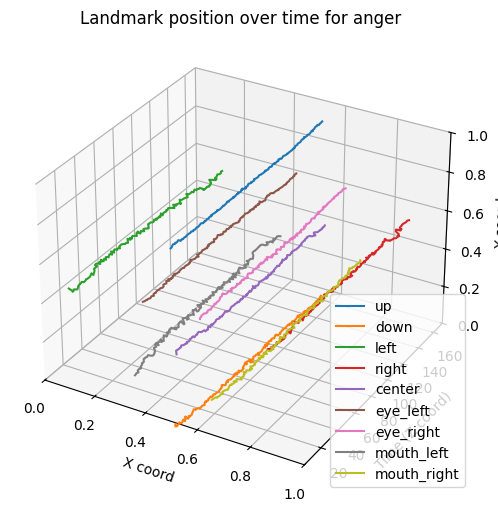

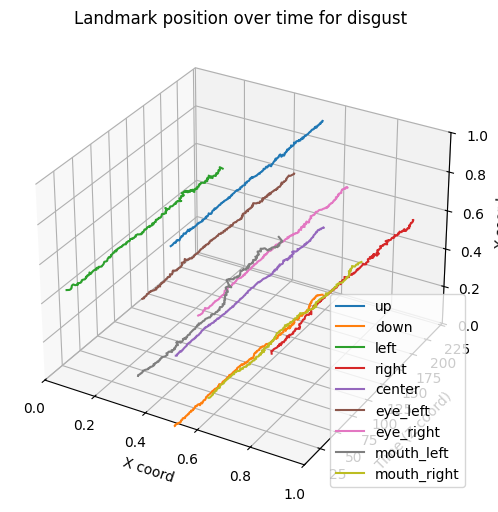

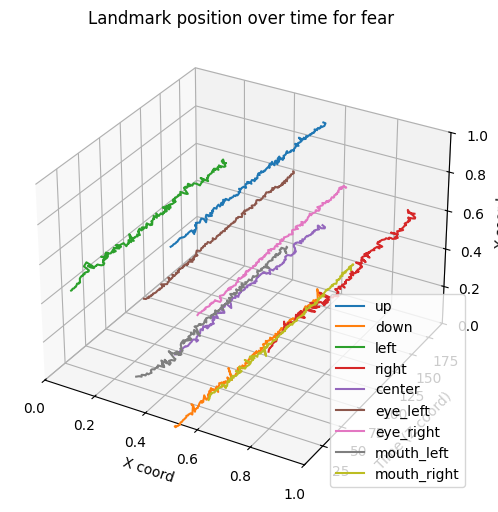

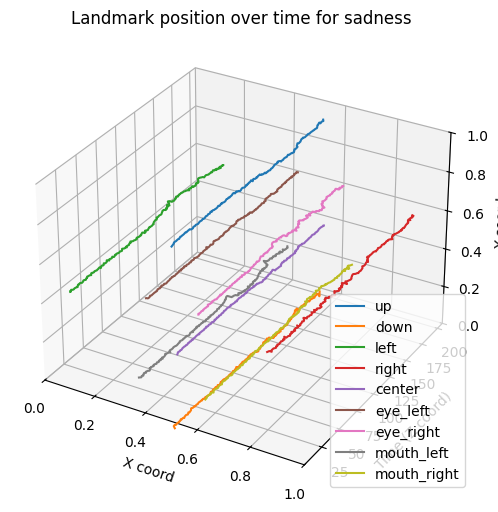

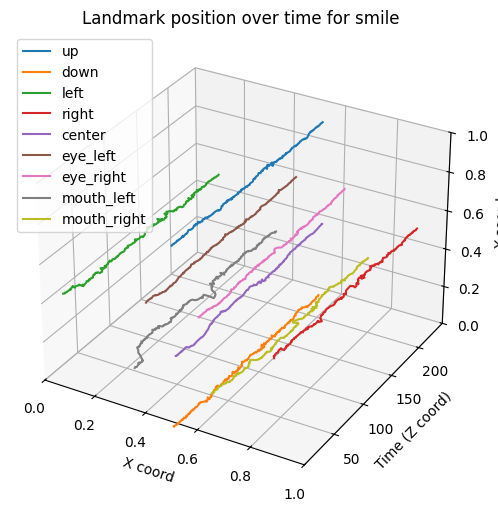

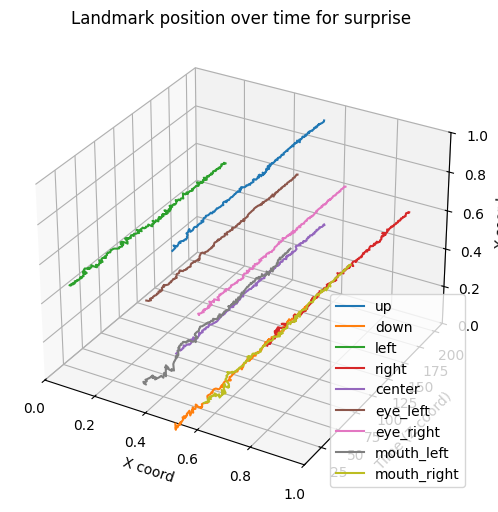

In [70]:
for emotion, coords_2d in emotions_landmarks_pos.items():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    z_values = np.arange(1, len(coords_2d) + 1)

    for area in LANDMARKS_FOR_COORDS.keys():
        area_coords_2d = [pos[area][0] for pos in coords_2d]
        x_coords = [c[0] for c in area_coords_2d]
        y_coords = [1 - c[1] for c in area_coords_2d]  # Invert Y-coordinates
        ax.plot(x_coords, z_values, y_coords, label=area)

    ax.set_xlim(0, 1)
    ax.set_ylim(1, len(coords_2d))
    ax.set_zlim(0, 1)
    ax.set_xlabel('X coord')
    ax.set_ylabel('Time (Z coord)')
    ax.set_zlabel('Y coord')
    ax.set_title(f'Landmark position over time for {emotion}')
    ax.legend()
    plt.show()